# Correlation between Sharma models and sPlot

In [1]:
from src.conf.conf import get_config


cfg = get_config()

In [ ]:
import pandas as pd

pred = (
    pd.read_csv(
        "/mnt/gsdata/projects/panops/inferenceresult_withtaxa.csv", index_col=0
    ).drop(
        columns=[
            "image",
            "pft",
            "Species",
            "Kingdom",
            "Phylum",
            "Class",
            "Order",
            "Family",
            "Genus",
        ]
    )
    .reset_index(drop=True)
)

pred.head()

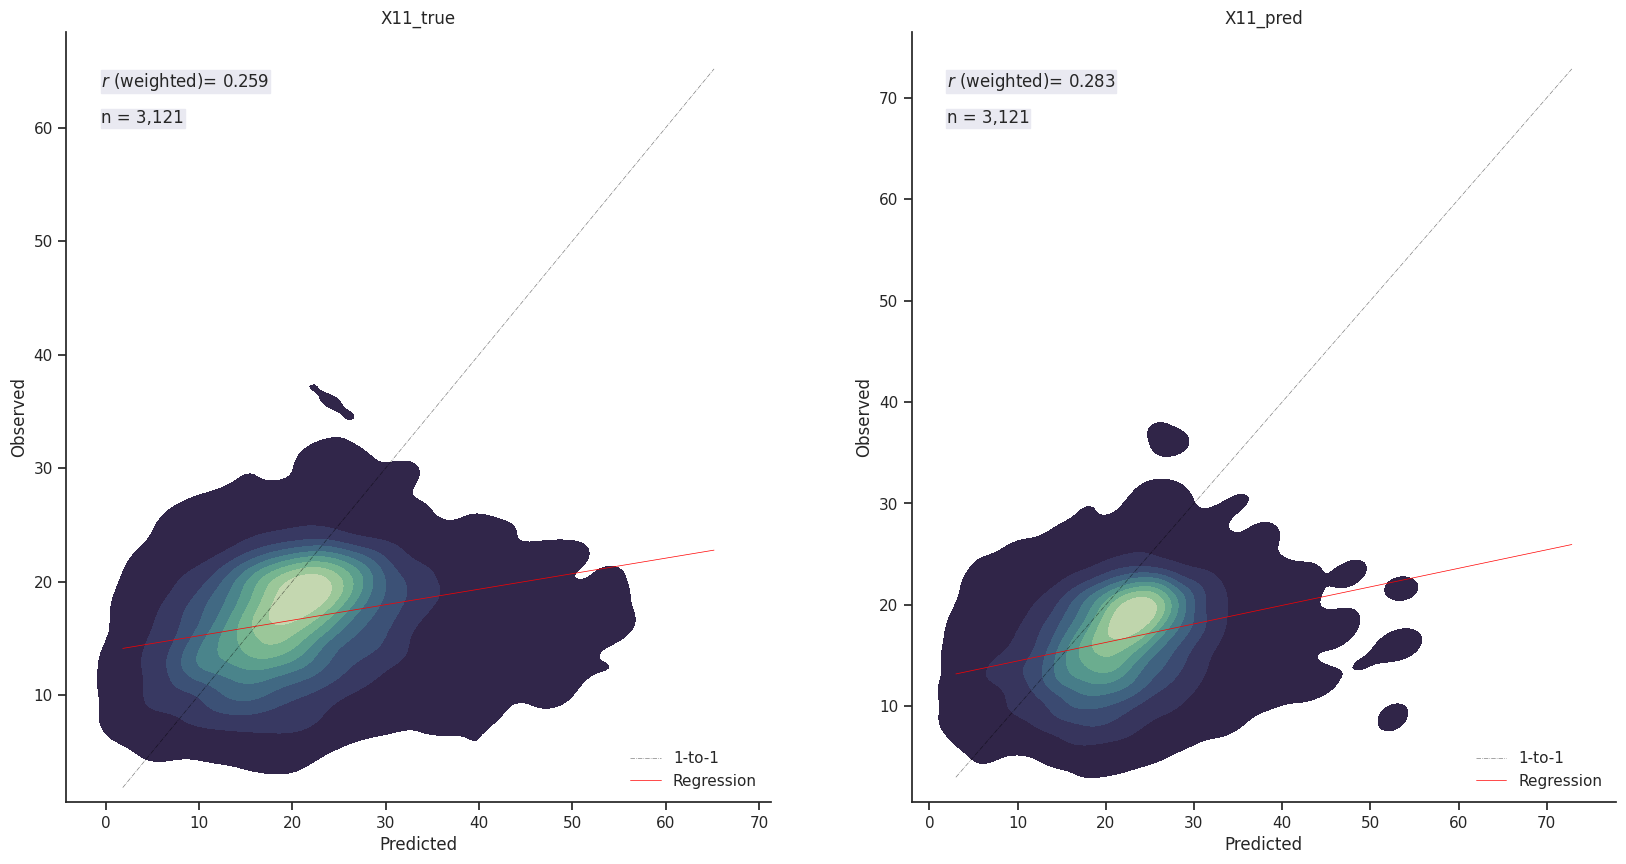

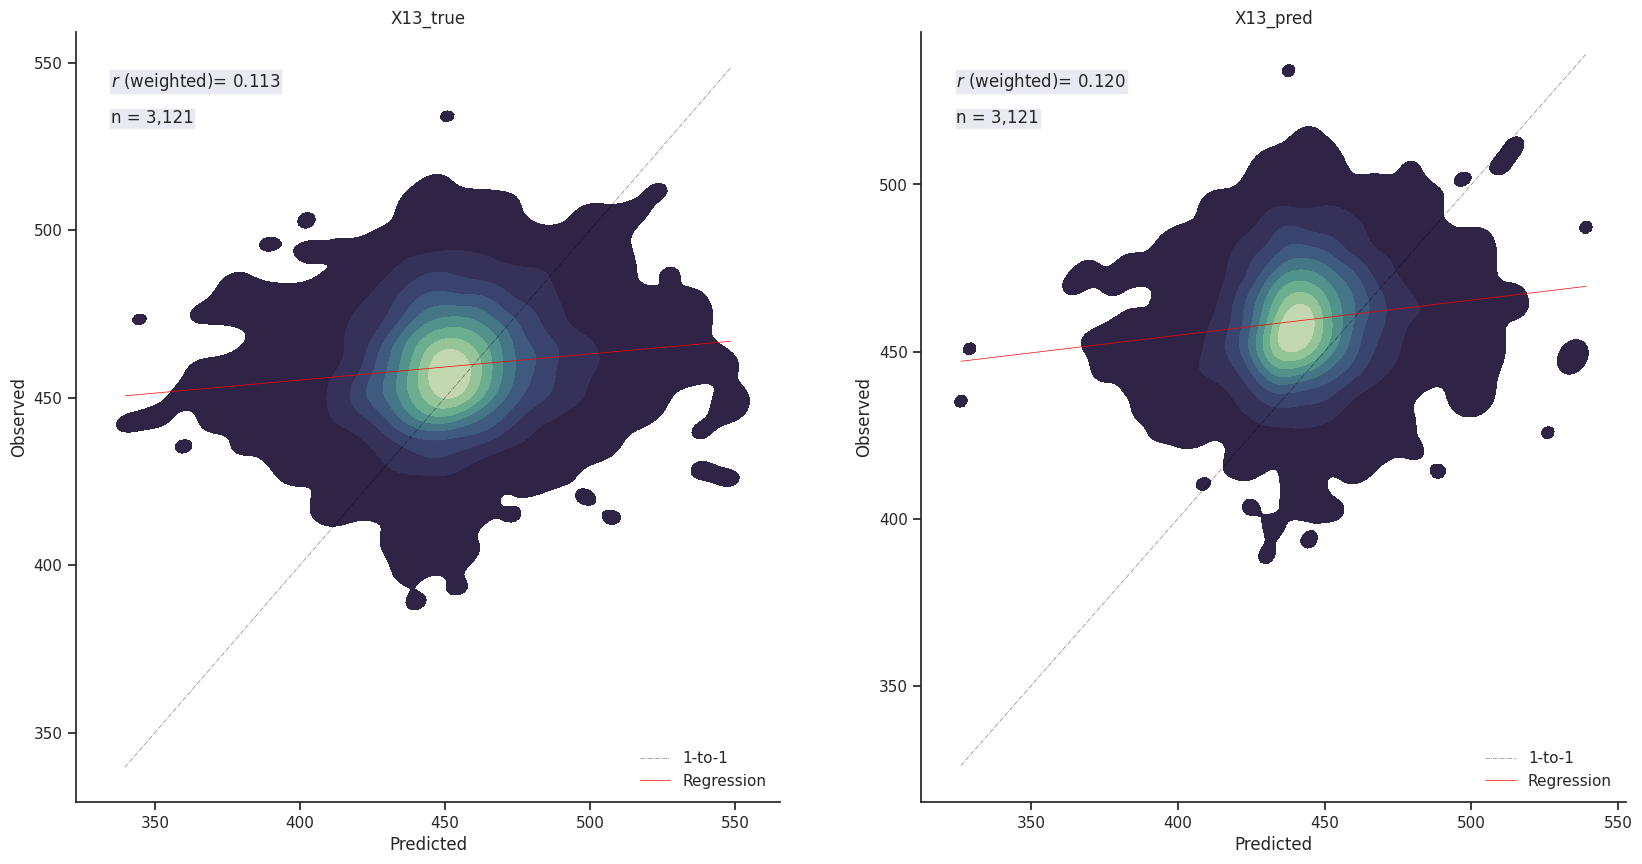

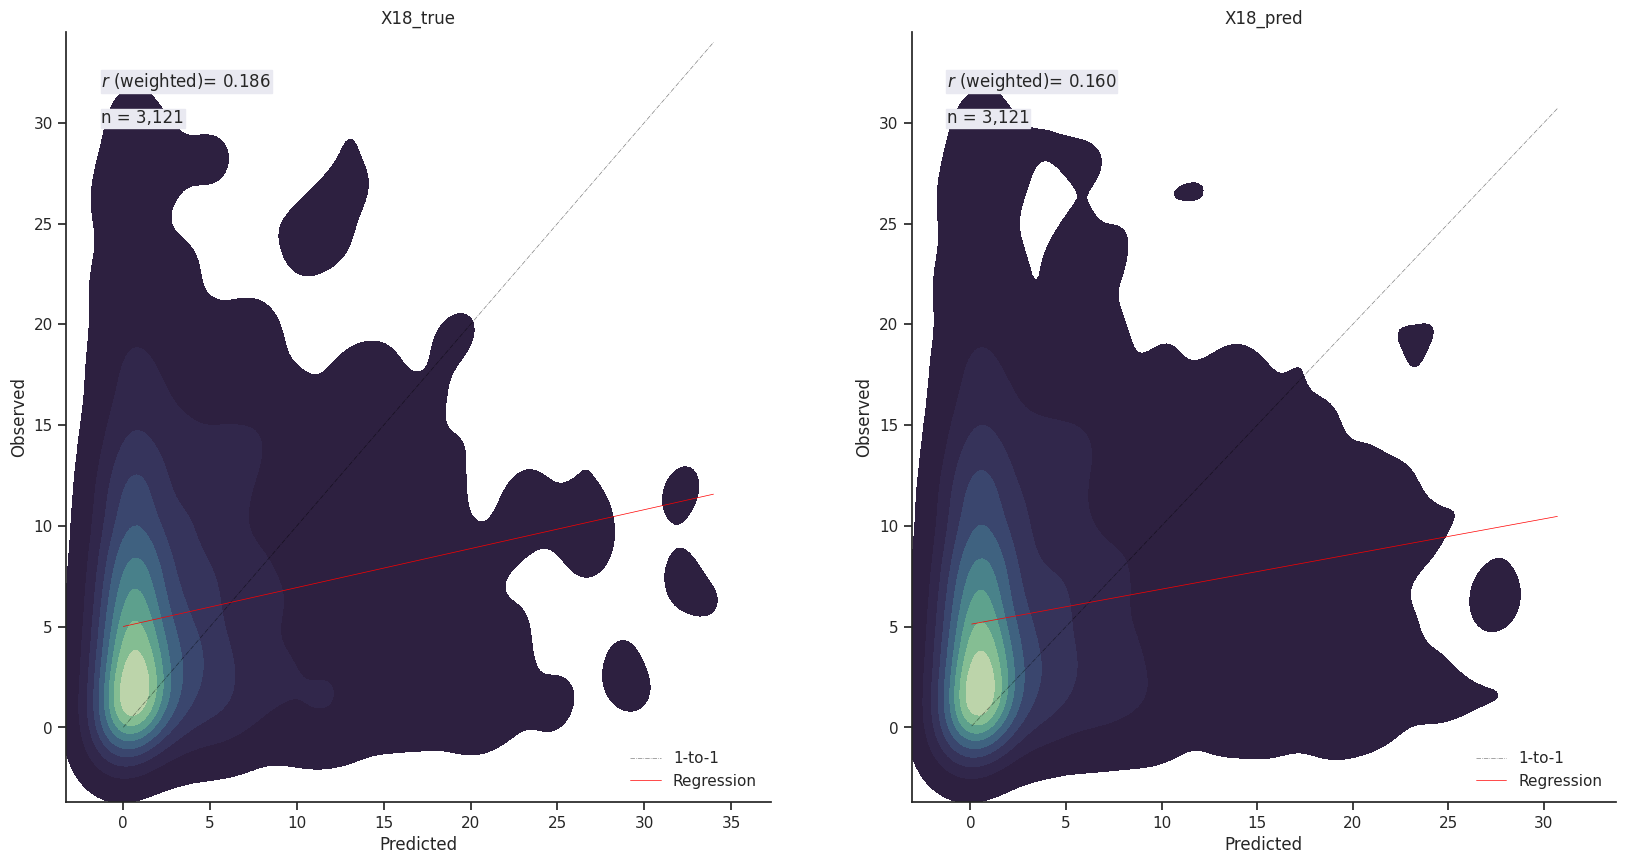

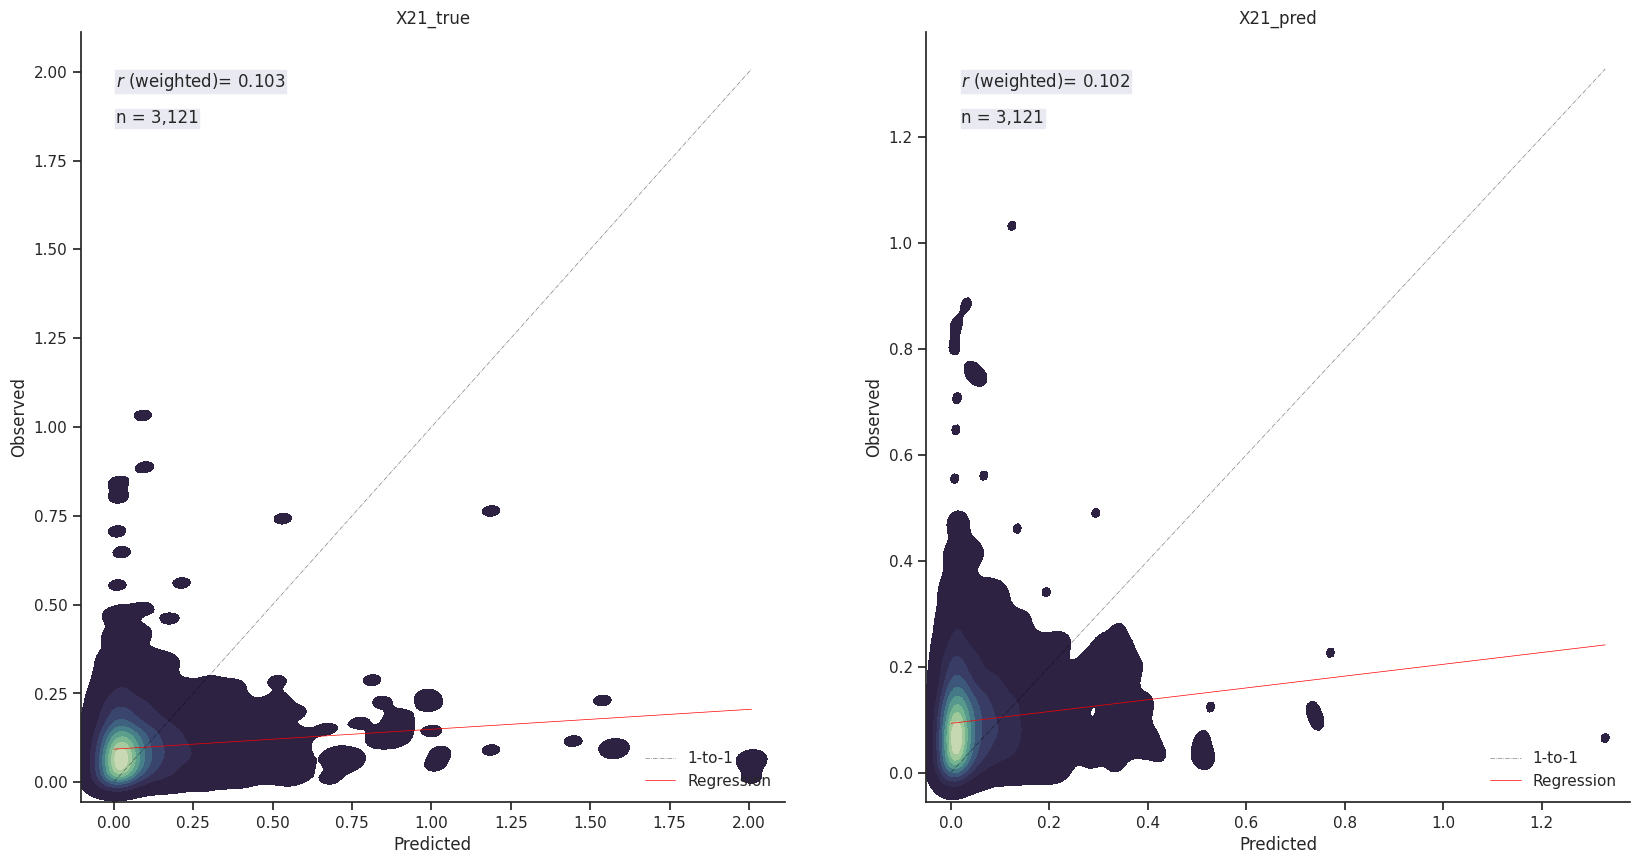

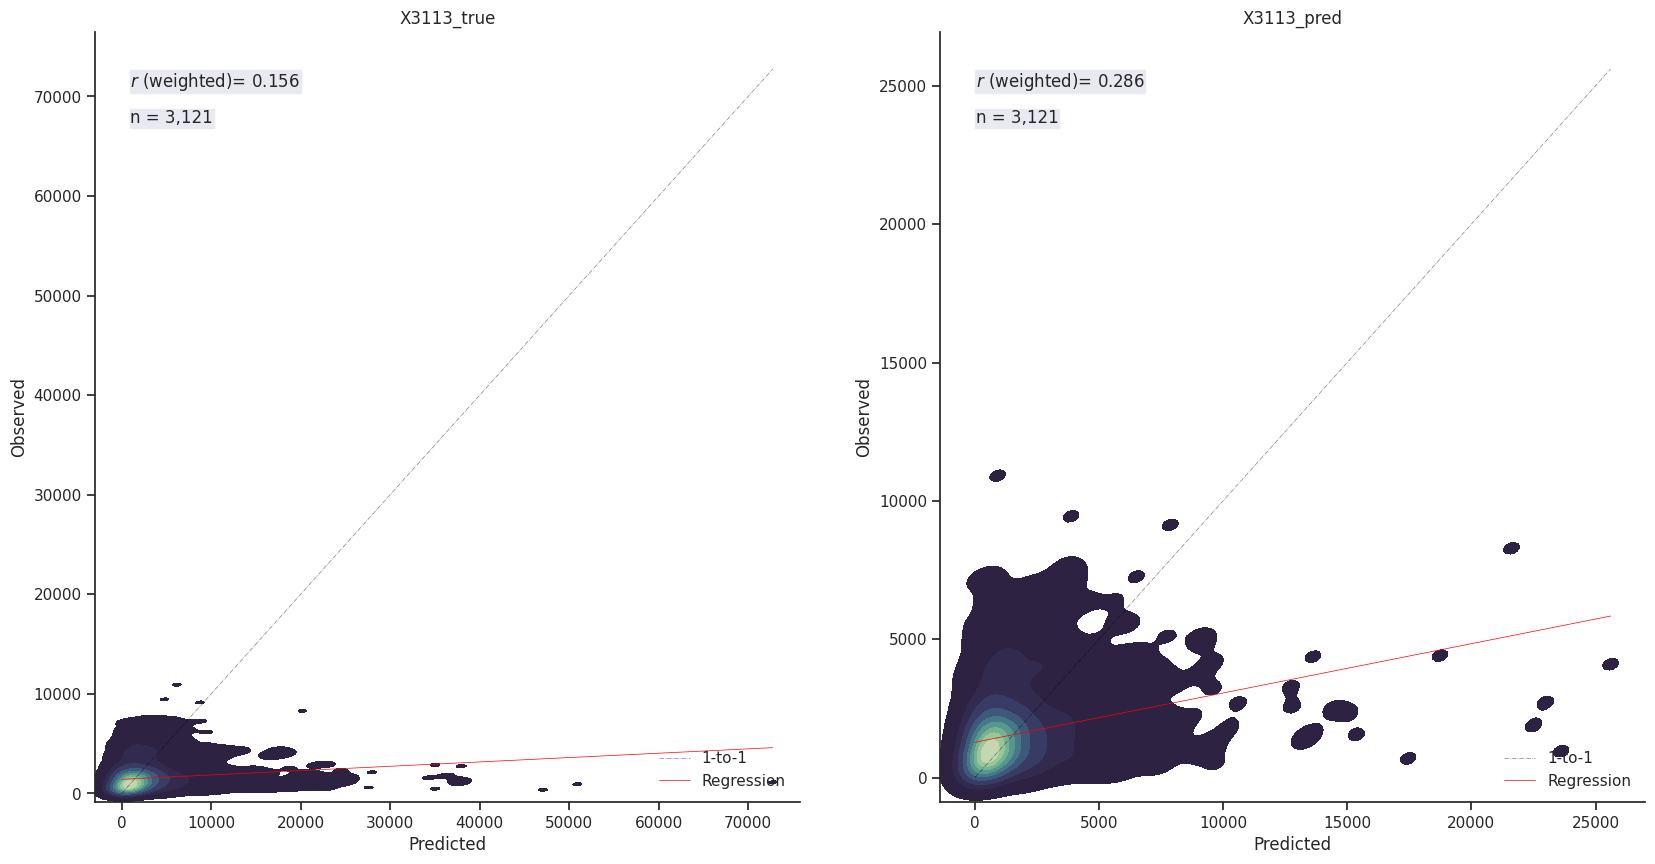

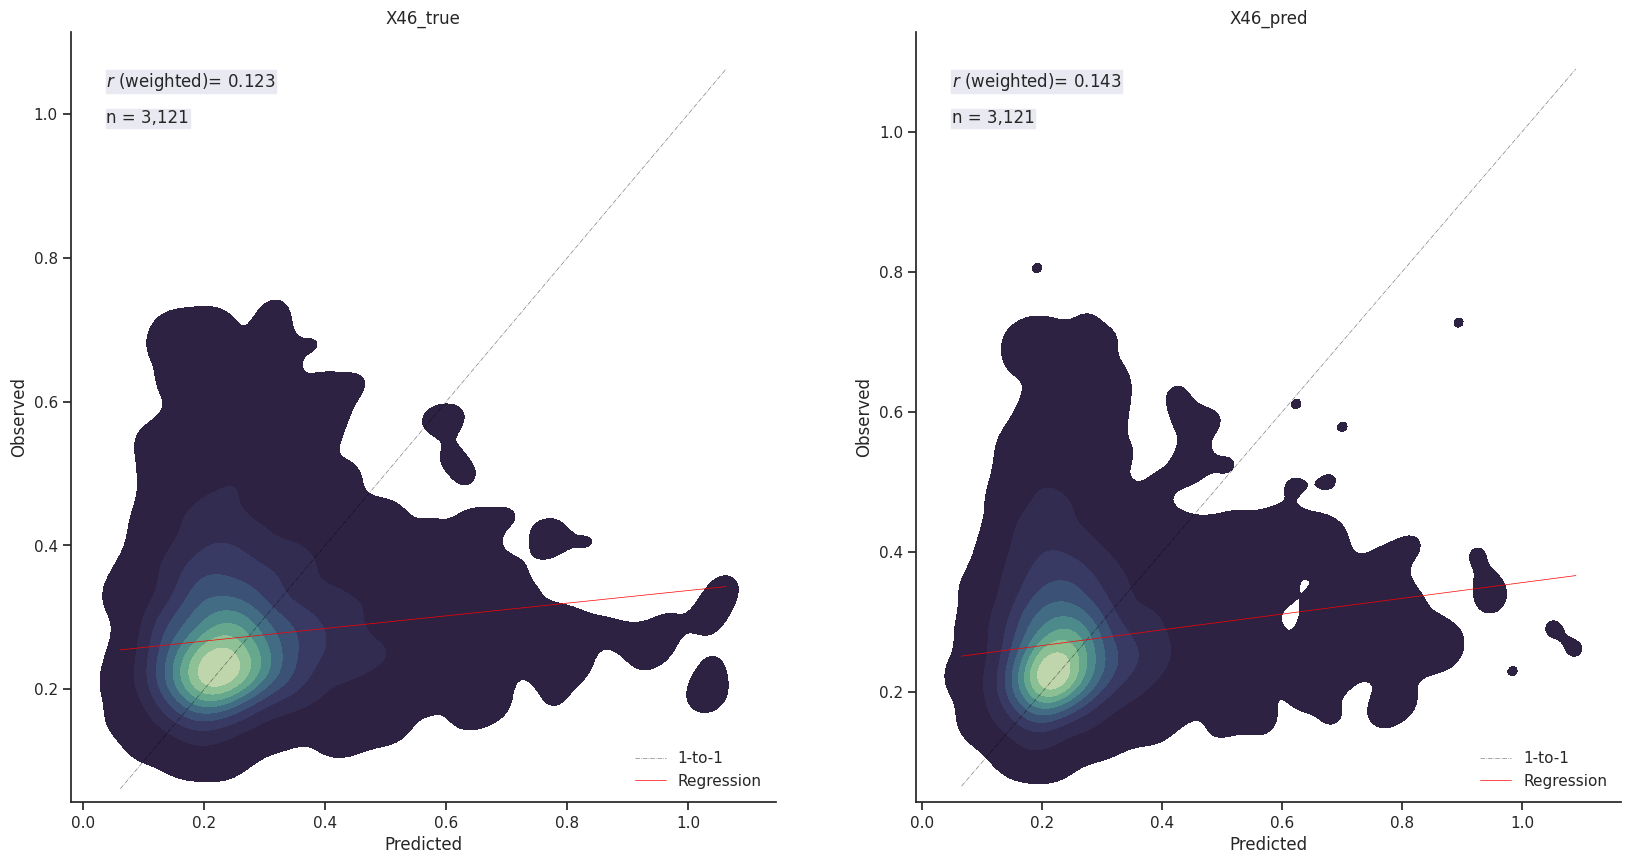

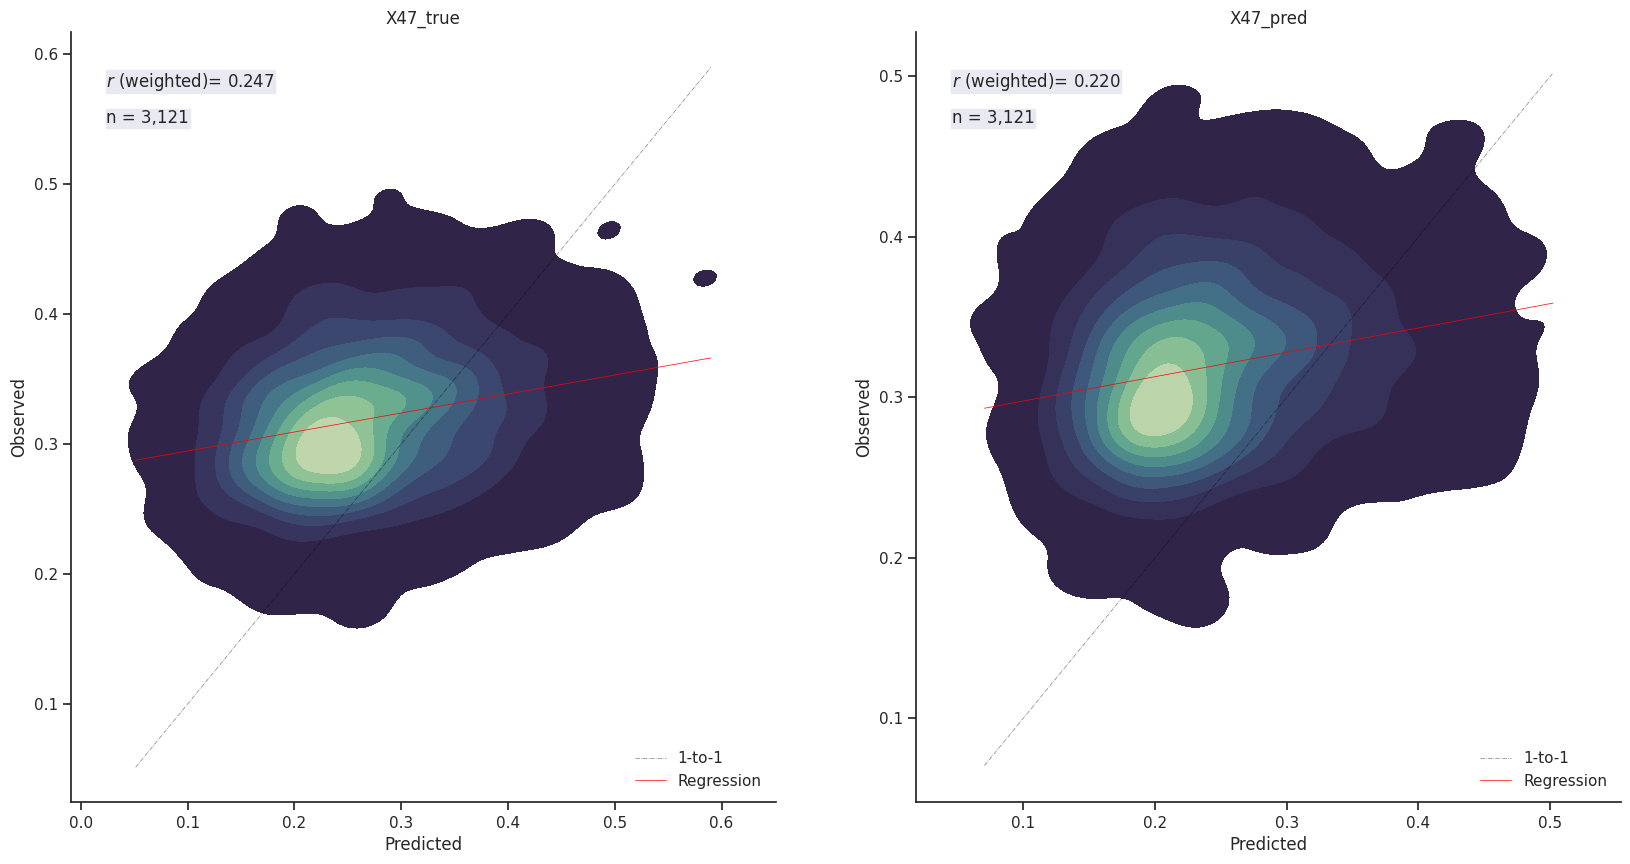

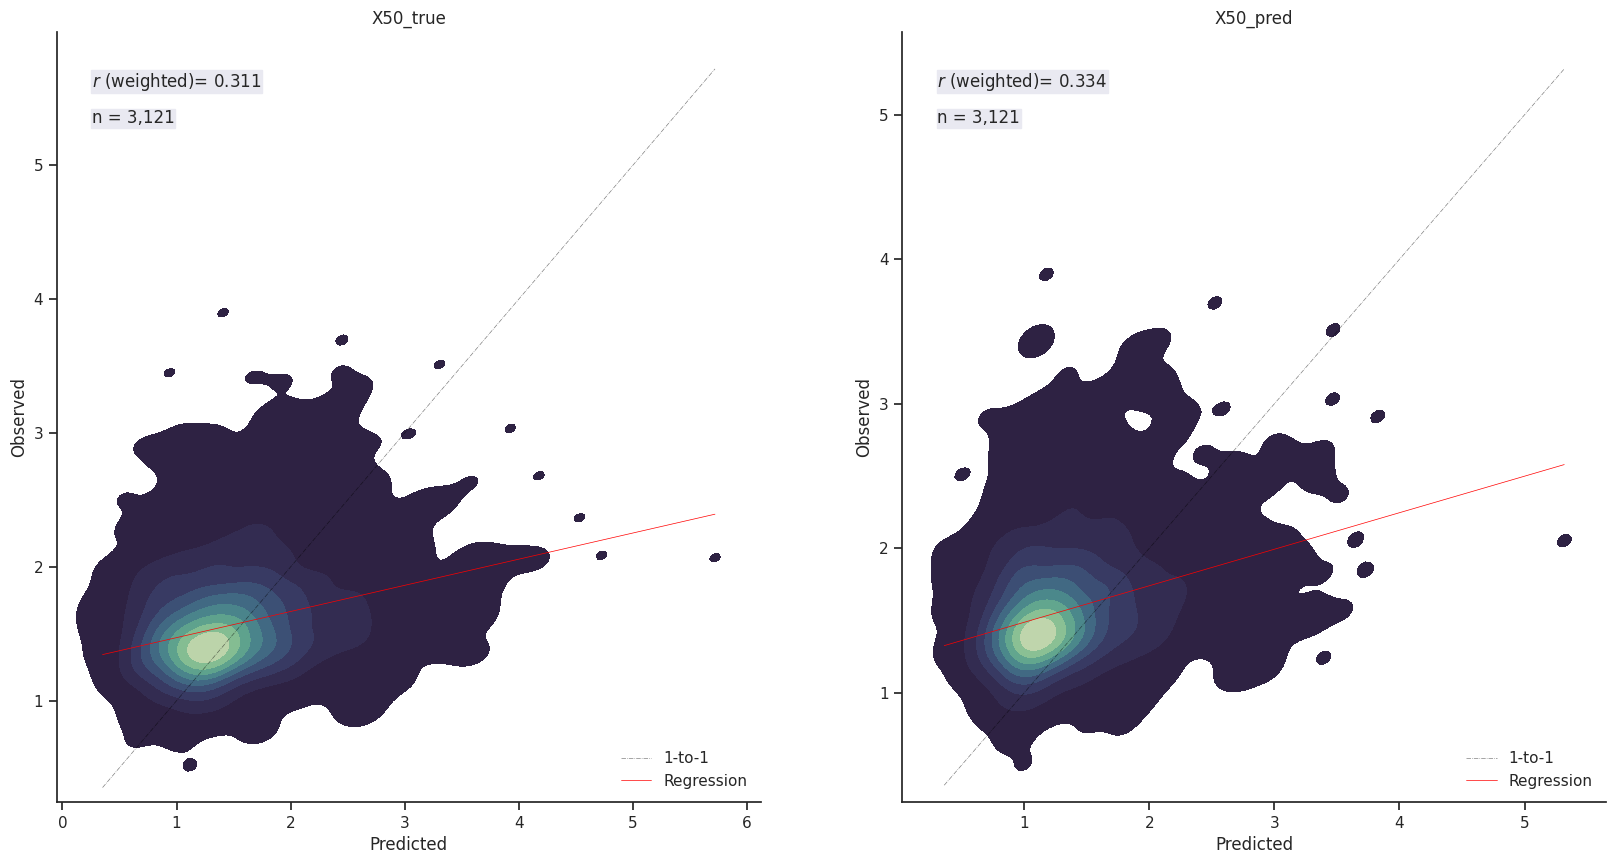

In [12]:
from pathlib import Path
from matplotlib import pyplot as plt
from src.utils.dataset_utils import get_y_fn, read_trait_map
from src.utils.df_utils import global_grid_df
from src.utils.spatial_utils import lat_weights, weighted_pearson_r
from src.visualization.model_assessment import plot_observed_vs_predicted
import seaborn as sns


trait_cols = [col for col in pred.columns if col.startswith("X")]
true_cols = sorted([col for col in trait_cols if col.endswith("true")])
pred_cols = sorted([col for col in trait_cols if col.endswith("pred")])

all_stats_path = Path("share", "sharma", "splot_corr.csv")

if all_stats_path.exists():
    all_stats = pd.read_csv(all_stats_path)
else:
    all_stats = pd.DataFrame(
        {"trait": [], "source": [], "resolution": [], "weighted_r": [], "r": []}
    )

for true_col, pred_col in zip(true_cols, pred_cols):
    trait = true_col.split("_")[0]
    grid_stat = "mean"

    splot_df = (
        read_trait_map(trait, "splot", band=1)
        .to_dataframe(name=trait)
        .drop(columns=["band", "spatial_ref"])
        .dropna()
    )

    true_df = global_grid_df(
        pred[["longitude", "latitude", true_col]],
        true_col,
        lon="longitude",
        lat="latitude",
        res=cfg.target_resolution,
        stats=[grid_stat],
    ).rename(columns={"mean": true_col})

    pred_df = global_grid_df(
        pred[["longitude", "latitude", pred_col]],
        pred_col,
        lon="longitude",
        lat="latitude",
        res=cfg.target_resolution,
        stats=[grid_stat],
    ).rename(columns={"mean": pred_col})

    splot_vs_true = true_df.join(splot_df, how="inner").rename(
        columns={trait: "observed", true_col: "predicted"}
    )
    splot_vs_pred = pred_df.join(splot_df, how="inner").rename(
        columns={trait: "observed", pred_col: "predicted"}
    )

    out_dir = Path("share", "sharma")
    combined = pd.concat(
        [
            splot_vs_true.rename(
                columns={"observed": f"{trait}_splot", "predicted": f"{trait}_true"}
            ),
            splot_vs_pred.rename(columns={"predicted": f"{trait}_pred"})[
                [f"{trait}_pred"]
            ],
        ],
        axis=1,
    )[[f"{trait}_splot", f"{trait}_true", f"{trait}_pred"]]
    combined_path = out_dir / "data" / f"{trait}_vs_splot_{cfg.model_res}deg.parquet"
    combined_path.parent.mkdir(parents=True, exist_ok=True)
    combined.reset_index().to_parquet(combined_path)

    # Get unique values of the "y" index
    lat_wts = lat_weights(
        splot_vs_true.index.get_level_values("y").unique().values, cfg.target_resolution
    )
    weighted_r_true = weighted_pearson_r(splot_vs_true, lat_wts)
    r_true = splot_vs_true.corr().loc["observed", "predicted"]
    weighted_r_pred = weighted_pearson_r(splot_vs_pred, lat_wts)
    r_pred = splot_vs_pred.corr().loc["observed", "predicted"]

    trait_stats_true = pd.DataFrame(
        {
            "trait": [true_col.split("_")[0]],
            "source": ["true"],
            "resolution": [cfg.target_resolution],
            "weighted_r": [weighted_r_true],
            "r": [r_true],
        }
    )
    trait_stats_pred = pd.DataFrame(
        {
            "trait": [true_col.split("_")[0]],
            "source": ["pred"],
            "resolution": [cfg.target_resolution],
            "weighted_r": [weighted_r_pred],
            "r": [r_pred],
        }
    )

    all_stats = pd.concat(
        [all_stats, trait_stats_true, trait_stats_pred], ignore_index=True
    ).drop_duplicates()

    with sns.plotting_context("notebook"), sns.axes_style("ticks"):
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        ax = ax.flatten()

        ax[0] = plot_observed_vs_predicted(
            ax[0],
            splot_vs_true.observed,
            splot_vs_true.predicted,
            true_col,
            log=False,
            density=True,
            show_r=True,
            manual_r=weighted_r_true,
            r_weighted=True,
        )

        ax[1] = plot_observed_vs_predicted(
            ax[1],
            splot_vs_pred.observed,
            splot_vs_pred.predicted,
            pred_col,
            log=False,
            density=True,
            show_r=True,
            manual_r=weighted_r_pred,
            r_weighted=True,
        )

        sns.despine()

        fig_path = out_dir / "plots" / f"{trait}_vs_splot_{cfg.model_res}deg.png"
        fig_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(fig_path, dpi=300)

all_stats.to_csv(all_stats_path, index=False)